# Hello Point Cloud Data Engineering

Example code how to preprocess and clean up Point Cloud Data

In [16]:
# Prerequisites:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

import open3d as o3d
import laspy as lp
from laspy import LazBackend

print("Python version: ", sys.version)
print("Open3D version: ", o3d.__version__)


Python version:  3.12.7 (tags/v3.12.7:0b05ead, Oct  1 2024, 03:06:41) [MSC v.1941 64 bit (AMD64)]
Open3D version:  0.19.0


### Get Open3D Sample Dataset

In [2]:
# Load a sample PLY file from Open3D's built-in data
sample_pcd = o3d.data.PLYPointCloud()
pcd = o3d.io.read_point_cloud(sample_pcd.path)

print("Point cloud loaded:")
print(pcd)
print(f"Number of points: {len(pcd.points)}")

# Visualize
o3d.visualization.draw_geometries([pcd], window_name="O3D Viewer", 
                                  width=800, height=600, point_show_normal=False)


Point cloud loaded:
PointCloud with 196133 points.
Number of points: 196133


### Shift and Center the point cloud

In [3]:
pcd_center = pcd.get_center()
print("Point cloud center: ", pcd_center)
# Translate the point cloud to the origin
pcd.translate(-pcd_center)

Point cloud center:  [2.14627542 1.91609881 1.57331578]


PointCloud with 196133 points.

### Downsample the Point Cloud

In [4]:
sampling_ratio = 0.5
pcd_down_sampled = pcd.random_down_sample(sampling_ratio)
print(f"Number of points: {len(pcd_down_sampled.points)}")
# Visualize
o3d.visualization.draw_geometries([pcd_down_sampled], window_name="O3D Viewer", 
                                  width=800, height=600, point_show_normal=False)

Number of points: 98066


### Outlier Removal

In [6]:
nn = 16
std_multiplier = 3
pcd_filtered, idx_filtered = pcd.remove_statistical_outlier(nn, std_multiplier)
print(f"Number of outliers: {len(pcd.points) - len(pcd_filtered.points)}")


Number of outliers: 1043


In [7]:
# Color outliers in red
outliers = pcd.select_by_index(idx_filtered, invert=True)
outliers.paint_uniform_color([1, 0, 0])
o3d.visualization.draw_geometries([pcd_filtered, outliers])

### Load LAS file

In [4]:
# Check that LazBackend is available
lp.LazBackend.detect_available()

(<LazBackend.LazrsParallel: 0>, <LazBackend.Lazrs: 1>, <LazBackend.Laszip: 2>)

In [ ]:
# The below LAZ file is too large for GitHub
file_path = "point_clouds_large/NZ19_Wellington.laz"
pc = lp.read(file_path)
#pc = lp.read(file_path, laz_backend=LazBackend.Laszip)

#### Extract to Numpy arrays

In [6]:
points = np.vstack((pc.x, pc.y, pc.z)).transpose()
colors = np.vstack((pc.red, pc.green, pc.blue)).transpose()

#### Random Subsampling

In [17]:
factor=160
print("Number of points before:", len(points))
decimated_points_random = points[::factor]
decimated_colors_random = colors[::factor]
print("Number of points after decimation:", len(decimated_points_random))


Number of points before: 13993118
Number of points after decimation: 87457


#### Grid Subsampling

In [12]:
voxel_size=6
np_voxels = np.ceil((np.max(points, axis=0) - np.min(points, axis=0))/voxel_size)

In [14]:
# For each voxel, check if it contains more than one point. If yes, keep it, we take note of 
# the points indexes to be linked to each voxel
non_empty_voxel_keys, inverse, nb_pts_per_voxel = np.unique(((points - np.min(points, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
idx_pts_vox_sorted=np.argsort(inverse)
print("Number of non empty voxels:", len(non_empty_voxel_keys))

Number of non empty voxels: 92090


In [15]:
# Loop over non_empty_voxel_keys numpy array, store voxel indices as keys in a dictionary

voxel_grid={}
grid_barycenter,grid_candidate_center=[],[]
last_seen=0

for idx,vox in enumerate(non_empty_voxel_keys):
    voxel_grid[tuple(vox)]=points[idx_pts_vox_sorted[last_seen:last_seen+nb_pts_per_voxel[idx]]]
    # Compute each voxel barycenter. and add it to a list
    grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))
    # Compute each voxel closest point to the barycenter and add it to a list
    grid_candidate_center.append(voxel_grid[tuple(vox)][np.linalg.norm(voxel_grid[tuple(vox)]-np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()])
    last_seen+=nb_pts_per_voxel[idx]

#### Visualize

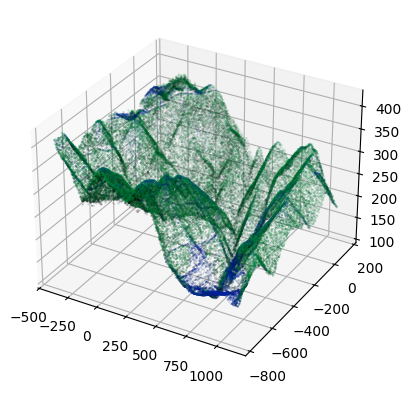

In [18]:
ax = plt.axes(projection='3d')
ax.scatter(decimated_points_random[:,0], decimated_points_random[:,1], decimated_points_random[:,2], c = decimated_colors_random/65535, s=0.01)
plt.show()